In [2]:
import sys
import os
script_dir = os.path.dirname(os.path.realpath('__file__'))
parent_dir = os.path.dirname(script_dir)
sys.path.insert(0, parent_dir)

import cnn_functions
import models
import pickle
from sklearn.model_selection import train_test_split
import torch
from torchvision import transforms
from torch.utils.data import Subset, DataLoader
from torch.utils.tensorboard import SummaryWriter

# Multiclass output

In [3]:
# Use the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

labels_map = {
    0: "REAL Truck",
    1: "REAL Car",
    2: "REAL Bird",
    3: "REAL Cat",
    4: "REAL Deer",
    5: "REAL Dog",
    6: "REAL Frog",
    7: "REAL Horse",
    8: "REAL Ship",
    9: "REAL Plane",
    10: "FAKE Truck",
    11: "FAKE Car",
    12: "FAKE Bird",
    13: "FAKE Cat",
    14: "FAKE Deer",
    15: "FAKE Dog",
    16: "FAKE Frog",
    17: "FAKE Horse",
    18: "FAKE Ship",
    19: "FAKE Plane"
}

# Compose the transform that will be applied to the data
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

# 100k samples for training
train_ds = cnn_functions.MulticlassCIFAKE(img_dir=os.path.join(script_dir, '../../dataset/train'), transform=transform)

# 10k samples for validation and 10k samples for testing
val_test_ds= cnn_functions.MulticlassCIFAKE(img_dir=os.path.join(script_dir, '../../dataset/test'), transform=transform)
idx_val, idx_test = train_test_split(
    range(len(val_test_ds)),
    test_size=0.5,  # 50-50 split
    stratify=val_test_ds.img_labels, # Uniform class distribution
    random_state=0
)
validation_ds = Subset(val_test_ds, idx_val)
test_ds = Subset(val_test_ds, idx_test)

cuda


# Feature extraction

/home/scardovi/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU1 NVIDIA GeForce GT 710 which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))




 - multiclass_feature_extraction_linear_lr1e-04_batch32_epochs10
Epoch 1; Train err = 65.38%; Val err = 65.48%; Loss: 2.5048
Epoch 2; Train err = 60.87%; Val err = 61.43%; Loss: 2.1166
Epoch 3; Train err = 59.30%; Val err = 59.54%; Loss: 2.0156
Epoch 4; Train err = 58.19%; Val err = 58.61%; Loss: 1.9595
Epoch 5; Train err = 57.40%; Val err = 57.66%; Loss: 1.9268
Epoch 10; Train err = 55.16%; Val err = 55.35%; Loss: 1.8561


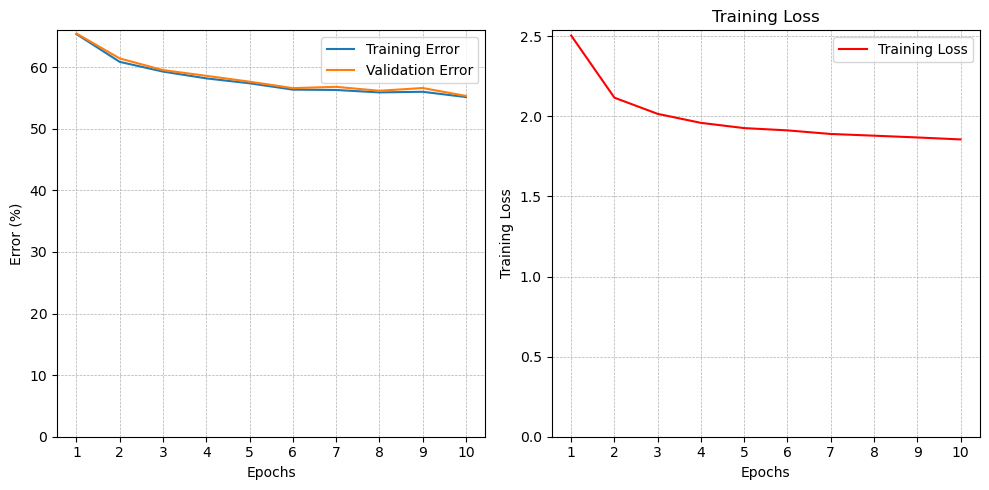



 - multiclass_feature_extraction_linear_lr1e-04_batch512_epochs10
Epoch 1; Train err = 92.91%; Val err = 92.67%; Loss: 3.2095
Epoch 2; Train err = 88.43%; Val err = 88.13%; Loss: 2.9883
Epoch 3; Train err = 83.90%; Val err = 83.41%; Loss: 2.8341
Epoch 4; Train err = 80.07%; Val err = 79.80%; Loss: 2.7153
Epoch 5; Train err = 77.12%; Val err = 76.96%; Loss: 2.6207
Epoch 10; Train err = 69.00%; Val err = 68.73%; Loss: 2.3500


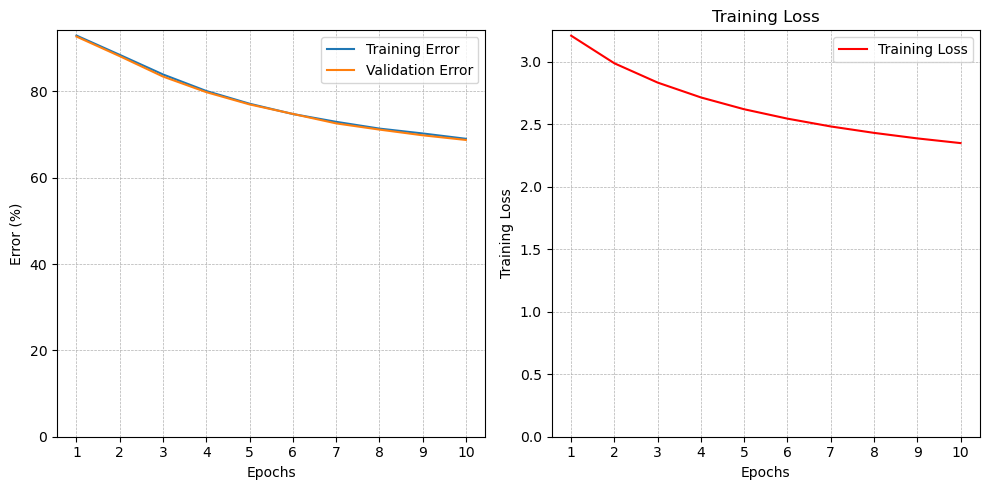



 - multiclass_feature_extraction_linear_lr1e-05_batch32_epochs10
Epoch 1; Train err = 88.78%; Val err = 88.37%; Loss: 3.0891
Epoch 2; Train err = 82.39%; Val err = 82.35%; Loss: 2.8215
Epoch 3; Train err = 77.45%; Val err = 77.60%; Loss: 2.6487
Epoch 4; Train err = 74.16%; Val err = 74.37%; Loss: 2.5293
Epoch 5; Train err = 71.75%; Val err = 71.90%; Loss: 2.4440
Epoch 10; Train err = 65.16%; Val err = 65.50%; Loss: 2.2105


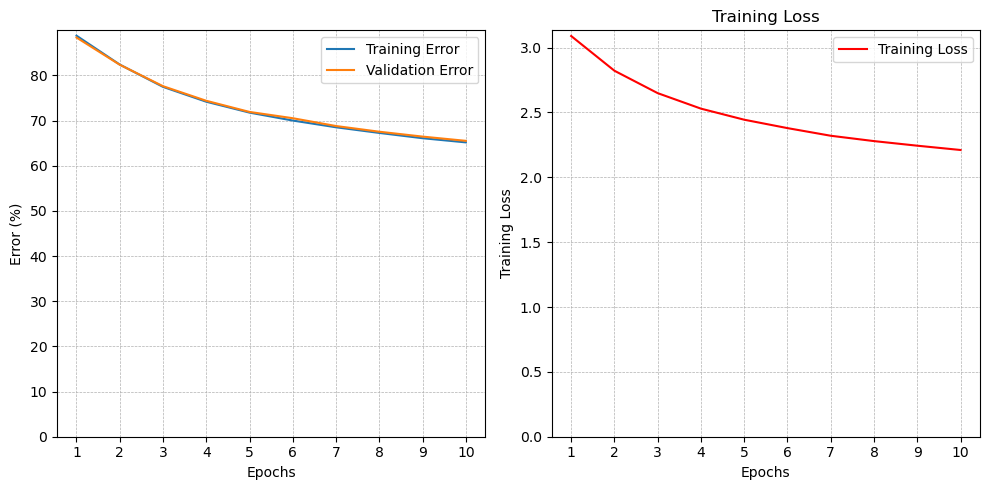



 - multiclass_feature_extraction_linear_lr1e-05_batch512_epochs10
Epoch 1; Train err = 94.77%; Val err = 94.68%; Loss: 3.2631
Epoch 2; Train err = 94.53%; Val err = 94.40%; Loss: 3.2084
Epoch 3; Train err = 94.25%; Val err = 94.07%; Loss: 3.1728
Epoch 4; Train err = 93.86%; Val err = 93.68%; Loss: 3.1453
Epoch 5; Train err = 93.43%; Val err = 93.21%; Loss: 3.1199
Epoch 10; Train err = 91.12%; Val err = 90.96%; Loss: 3.0223


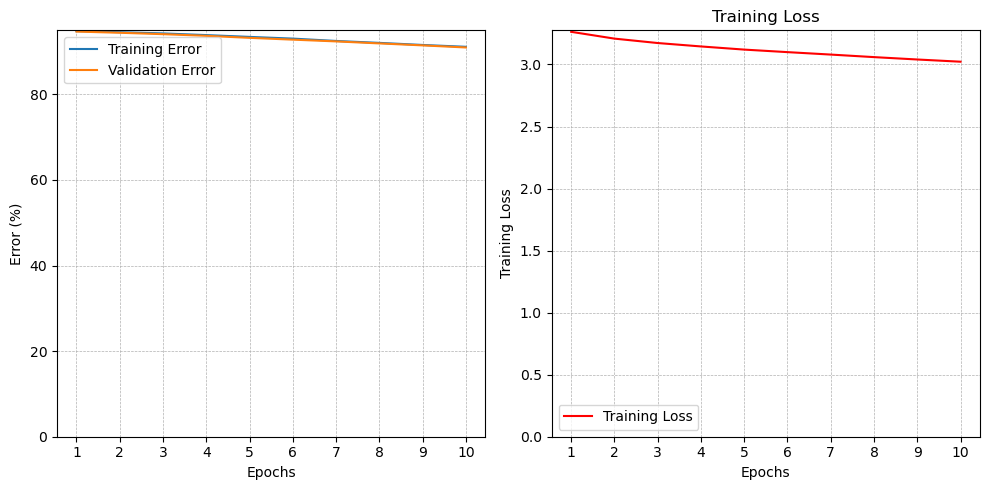

"        torch.save(model.state_dict(), './weights/' + model_name + '.pth')\n        stats_dict = {\n            'train_err': train_err,\n            'val_err': val_err,\n            'train_loss': train_loss\n        }\n        with open('./stats/' + model_name + '.pkl', 'wb') as f:\n            pickle.dump(stats_dict, f)"

In [4]:
model_init_function = models.multiclass_feature_extraction_linear
epochs = 10
learning_rates = [0.0001, 0.00001]
batch_sizes = [32, 512]

val_batch_size = 1000
val_dl = DataLoader(validation_ds, batch_size=val_batch_size)

for lr in learning_rates:
    for batch_size in batch_sizes:
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

        # Initialize the model
        model = model_init_function()
        model = model.to(device)
        model_name = f"{model_init_function.__name__}_lr{lr:.0e}_batch{batch_size}_epochs{epochs}"
        print("\n\n - " + model_name)
        writer = SummaryWriter('logs/'+model_name)

        # Train the model
        train_err, val_err, train_loss = cnn_functions.train_network(model, device, lr, epochs, train_dl, val_dl, writer)
        cnn_functions.plot_training_stats(train_err, val_err, train_loss)
        writer.close()
        # Save the progress
'''        torch.save(model.state_dict(), './weights/' + model_name + '.pth')
        stats_dict = {
            'train_err': train_err,
            'val_err': val_err,
            'train_loss': train_loss
        }
        with open('./stats/' + model_name + '.pkl', 'wb') as f:
            pickle.dump(stats_dict, f)'''

# Feature extraction (1 hidden layer)



 - multiclass_extraction_hidden_lr0001_batch4_epochs30

Epoch 1; Train err = 74.29; Val err = 73.93; Loss: 2.5641
Epoch 2; Train err = 69.48; Val err = 69.48; Loss: 2.4043
Epoch 3; Train err = 71.11; Val err = 71.16; Loss: 2.3715
Epoch 4; Train err = 68.70; Val err = 68.59; Loss: 2.3533
Epoch 5; Train err = 68.45; Val err = 68.68; Loss: 2.3512
Epoch 10; Train err = 68.02; Val err = 67.71; Loss: 2.3249
Epoch 15; Train err = 67.36; Val err = 67.51; Loss: 2.3217
Epoch 20; Train err = 69.90; Val err = 69.82; Loss: 2.3148
Epoch 25; Train err = 66.41; Val err = 66.11; Loss: 2.3110
Epoch 30; Train err = 67.62; Val err = 68.12; Loss: 2.3147


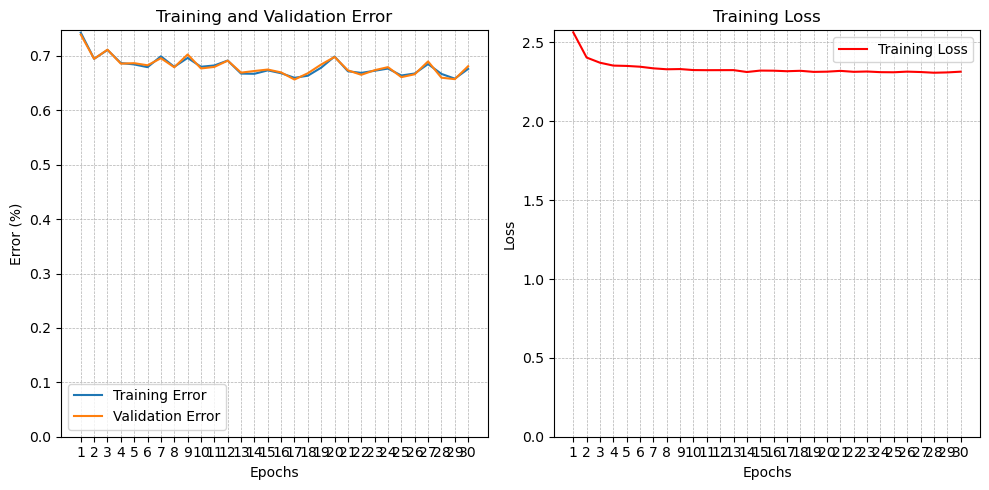



 - multiclass_extraction_hidden_lr0001_batch256_epochs30

Epoch 1; Train err = 67.02; Val err = 67.52; Loss: 2.7411
Epoch 2; Train err = 61.73; Val err = 62.19; Loss: 2.3281
Epoch 3; Train err = 59.46; Val err = 60.17; Loss: 2.1646
Epoch 4; Train err = 57.98; Val err = 58.57; Loss: 2.0844
Epoch 5; Train err = 57.26; Val err = 58.26; Loss: 2.0322
Epoch 10; Train err = 54.65; Val err = 55.30; Loss: 1.9054
Epoch 15; Train err = 53.45; Val err = 54.64; Loss: 1.8528
Epoch 20; Train err = 52.29; Val err = 53.51; Loss: 1.8191
Epoch 25; Train err = 51.66; Val err = 53.01; Loss: 1.7937
Epoch 30; Train err = 50.92; Val err = 52.65; Loss: 1.7731


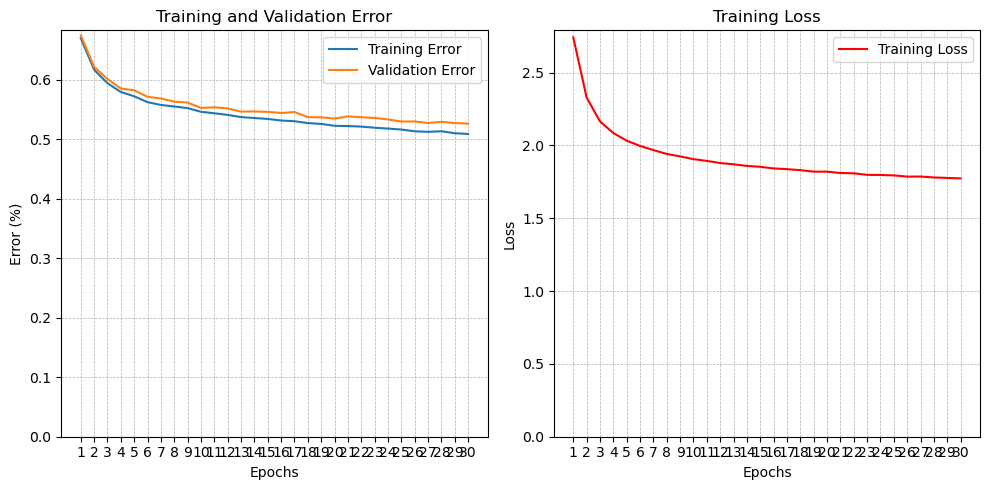



 - multiclass_extraction_hidden_lr-05_batch4_epochs30

Epoch 1; Train err = 82.03; Val err = 82.60; Loss: 2.8912
Epoch 2; Train err = 75.79; Val err = 75.98; Loss: 2.6644
Epoch 3; Train err = 73.08; Val err = 73.50; Loss: 2.5572
Epoch 4; Train err = 73.50; Val err = 73.17; Loss: 2.4932
Epoch 5; Train err = 71.05; Val err = 71.71; Loss: 2.4555
Epoch 10; Train err = 71.18; Val err = 71.35; Loss: 2.3667
Epoch 15; Train err = 69.21; Val err = 69.06; Loss: 2.3349
Epoch 20; Train err = 67.97; Val err = 68.05; Loss: 2.3187
Epoch 25; Train err = 69.21; Val err = 69.06; Loss: 2.3122
Epoch 30; Train err = 67.00; Val err = 67.74; Loss: 2.2981


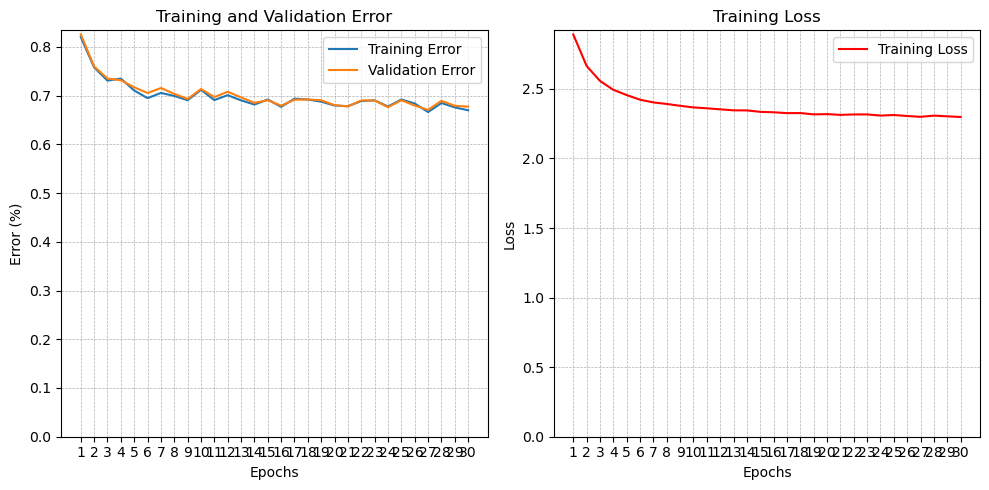



 - multiclass_extraction_hidden_lr-05_batch256_epochs30

Epoch 1; Train err = 91.85; Val err = 91.54; Loss: 3.0482
Epoch 2; Train err = 86.89; Val err = 86.83; Loss: 2.9648
Epoch 3; Train err = 82.65; Val err = 82.31; Loss: 2.9112
Epoch 4; Train err = 78.89; Val err = 78.63; Loss: 2.8545
Epoch 5; Train err = 75.72; Val err = 75.84; Loss: 2.7935
Epoch 10; Train err = 67.29; Val err = 67.24; Loss: 2.5187
Epoch 15; Train err = 63.86; Val err = 64.23; Loss: 2.3560
Epoch 20; Train err = 61.77; Val err = 62.43; Loss: 2.2575
Epoch 25; Train err = 60.37; Val err = 60.89; Loss: 2.1861
Epoch 30; Train err = 59.43; Val err = 60.27; Loss: 2.1332


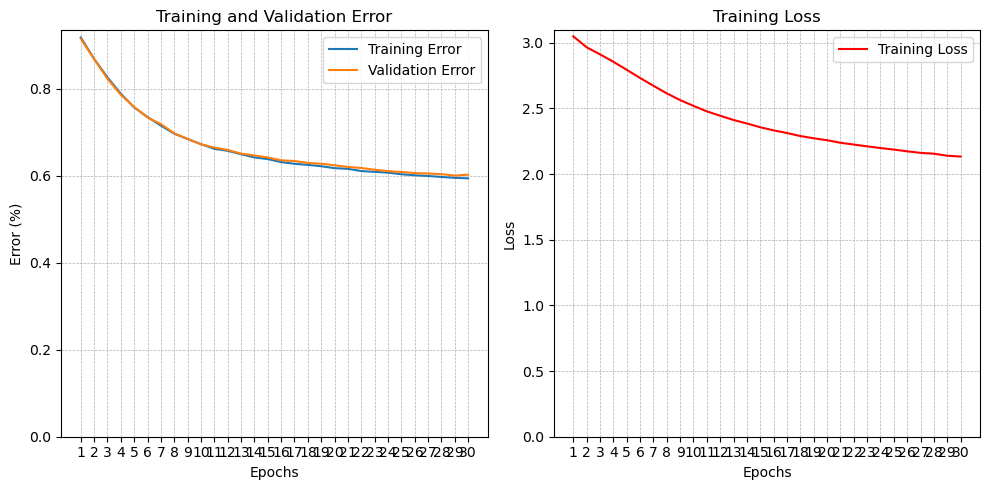

In [ ]:
model_init_function = models.multiclass_feature_extraction_1hidden
epochs = 30
learning_rates = [0.0001, 0.00001]
batch_sizes = [32, 512]

val_batch_size = 1000
val_dl = DataLoader(validation_ds, batch_size=val_batch_size)

for lr in learning_rates:
    for batch_size in batch_sizes:
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

        # Initialize the model
        model = model_init_function()
        model = model.to(device)
        model_name = f"{model}_lr{lr:.0e}_batch{batch_size}_epochs{epochs}"
        print("\n\n - " + model_name)

        # Train the model
        train_err, val_err, train_loss = cnn_functions.train_network(model, device, lr, epochs, train_dl, val_dl)
        cnn_functions.plot_training_stats(train_err, val_err, train_loss)
        
        # Save the progress
        torch.save(model.state_dict(), './weights/' + model_name + '.pth')
        stats_dict = {
            'train_err': train_err,
            'val_err': val_err,
            'train_loss': train_loss
        }
        with open('./stats/' + model_name + '.pkl', 'wb') as f:
            pickle.dump(stats_dict, f)

# Feature extraction (2 hidden layers)



 - multiclass_extraction_double_hidden0001_batch4_epochs30

Epoch 1; Train err = 74.52; Val err = 75.00; Loss: 2.7100
Epoch 2; Train err = 73.24; Val err = 73.07; Loss: 2.5275
Epoch 3; Train err = 71.96; Val err = 72.13; Loss: 2.4867
Epoch 4; Train err = 71.28; Val err = 71.17; Loss: 2.4604
Epoch 5; Train err = 69.74; Val err = 69.21; Loss: 2.4448
Epoch 10; Train err = 69.67; Val err = 69.88; Loss: 2.4178
Epoch 15; Train err = 69.01; Val err = 68.98; Loss: 2.4034
Epoch 20; Train err = 68.33; Val err = 68.30; Loss: 2.4045
Epoch 25; Train err = 68.18; Val err = 68.03; Loss: 2.3897
Epoch 30; Train err = 66.85; Val err = 67.32; Loss: 2.3874


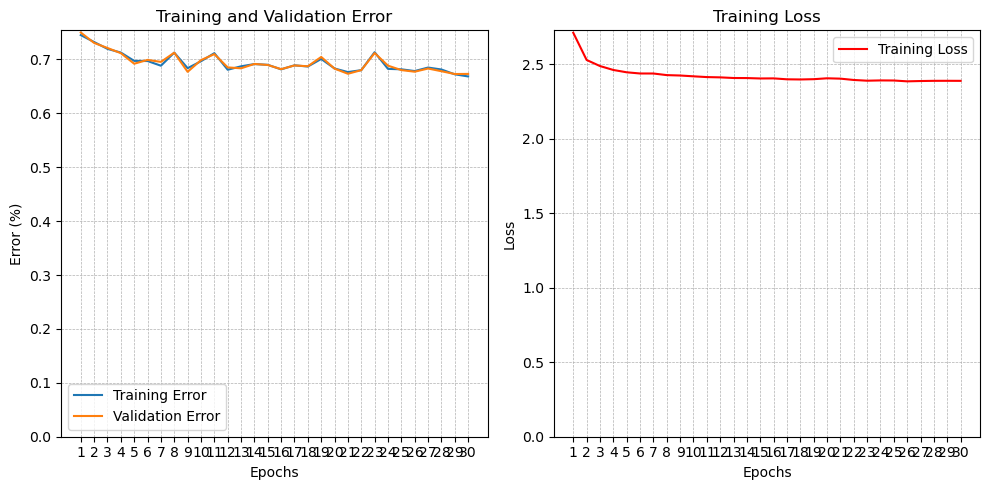



 - multiclass_extraction_double_hidden0001_batch256_epochs30

Epoch 1; Train err = 76.41; Val err = 76.34; Loss: 2.9301
Epoch 2; Train err = 68.03; Val err = 68.05; Loss: 2.6355
Epoch 3; Train err = 64.15; Val err = 64.59; Loss: 2.4327
Epoch 4; Train err = 62.61; Val err = 62.88; Loss: 2.3216
Epoch 5; Train err = 61.40; Val err = 61.93; Loss: 2.2513
Epoch 10; Train err = 58.02; Val err = 58.83; Loss: 2.0957
Epoch 15; Train err = 56.40; Val err = 57.44; Loss: 2.0306
Epoch 20; Train err = 55.14; Val err = 56.17; Loss: 1.9886
Epoch 25; Train err = 54.33; Val err = 55.79; Loss: 1.9620
Epoch 30; Train err = 53.61; Val err = 55.07; Loss: 1.9409


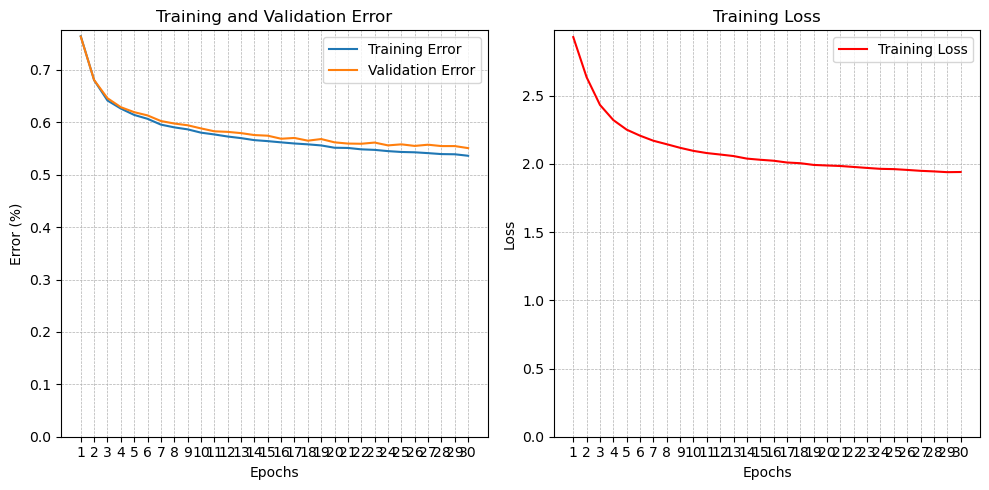



 - multiclass_extraction_double_hidden-05_batch4_epochs30

Epoch 1; Train err = 86.20; Val err = 85.91; Loss: 2.9750
Epoch 2; Train err = 81.27; Val err = 81.33; Loss: 2.8585
Epoch 3; Train err = 78.93; Val err = 79.61; Loss: 2.7489
Epoch 4; Train err = 77.51; Val err = 77.61; Loss: 2.6784
Epoch 5; Train err = 76.56; Val err = 77.07; Loss: 2.6301
Epoch 10; Train err = 71.63; Val err = 72.11; Loss: 2.5138
Epoch 15; Train err = 70.87; Val err = 71.28; Loss: 2.4640
Epoch 20; Train err = 70.43; Val err = 70.79; Loss: 2.4424
Epoch 25; Train err = 70.33; Val err = 70.28; Loss: 2.4272
Epoch 30; Train err = 69.95; Val err = 70.00; Loss: 2.4154


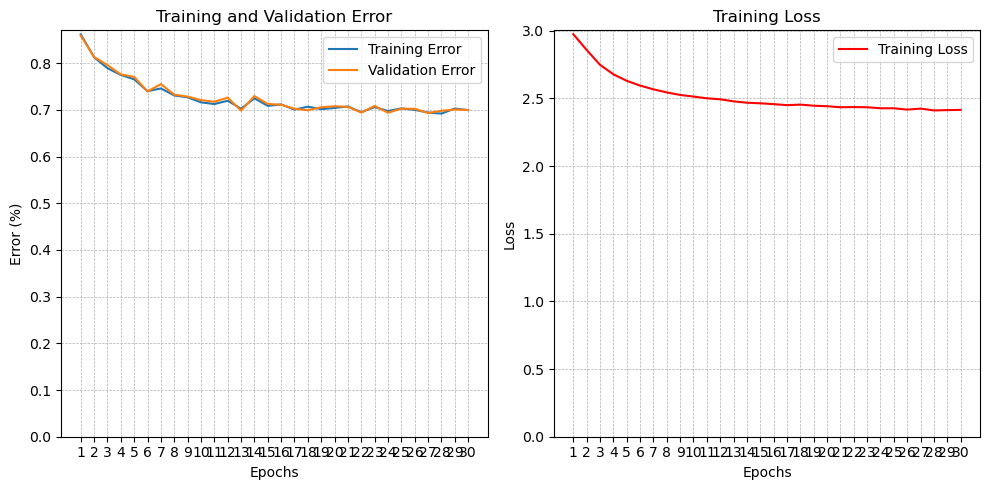



 - multiclass_extraction_double_hidden-05_batch256_epochs30

Epoch 1; Train err = 93.26; Val err = 94.03; Loss: 3.0130
Epoch 2; Train err = 91.05; Val err = 91.49; Loss: 2.9933
Epoch 3; Train err = 88.47; Val err = 88.72; Loss: 2.9814
Epoch 4; Train err = 85.44; Val err = 86.04; Loss: 2.9662
Epoch 5; Train err = 83.27; Val err = 83.50; Loss: 2.9476
Epoch 10; Train err = 74.42; Val err = 75.29; Loss: 2.8109
Epoch 15; Train err = 70.67; Val err = 71.29; Loss: 2.6637
Epoch 20; Train err = 67.80; Val err = 68.74; Loss: 2.5508
Epoch 25; Train err = 65.78; Val err = 66.66; Loss: 2.4700
Epoch 30; Train err = 64.37; Val err = 64.85; Loss: 2.4079


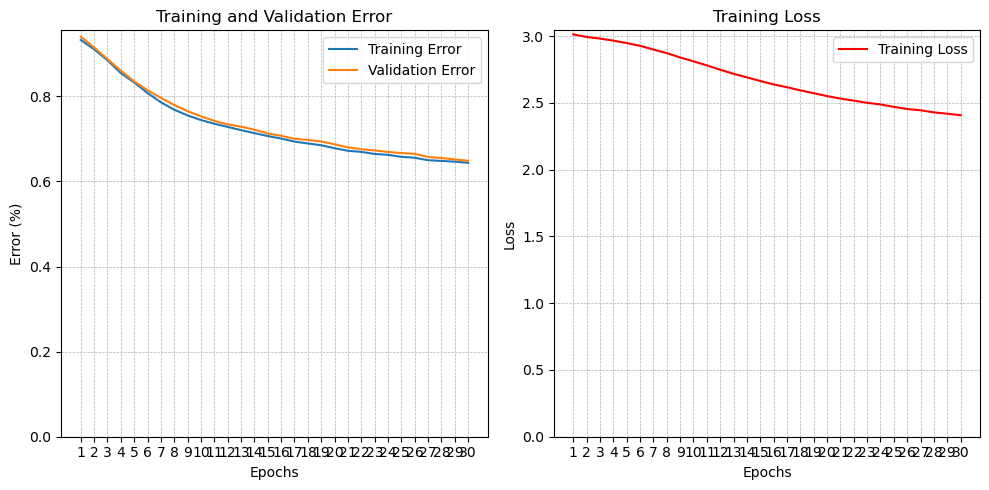

In [ ]:
model_init_function = models.multiclass_feature_extraction_2hidden
epochs = 30
learning_rates = [0.0001, 0.00001]
batch_sizes = [32, 512]

val_batch_size = 1000
val_dl = DataLoader(validation_ds, batch_size=val_batch_size)

for lr in learning_rates:
    for batch_size in batch_sizes:
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

        # Initialize the model
        model = model_init_function()
        model = model.to(device)
        model_name = f"{model}_lr{lr:.0e}_batch{batch_size}_epochs{epochs}"
        print("\n\n - " + model_name)

        # Train the model
        train_err, val_err, train_loss = cnn_functions.train_network(model, device, lr, epochs, train_dl, val_dl)
        cnn_functions.plot_training_stats(train_err, val_err, train_loss)
        
        # Save the progress
        torch.save(model.state_dict(), './weights/' + model_name + '.pth')
        stats_dict = {
            'train_err': train_err,
            'val_err': val_err,
            'train_loss': train_loss
        }
        with open('./stats/' + model_name + '.pkl', 'wb') as f:
            pickle.dump(stats_dict, f)

# Fine tuning

In [7]:
model_init_function = models.multiclass_finetuning
epochs = 30
learning_rates = [0.0001, 0.00001]
batch_sizes = [32, 512]

val_batch_size = 1000
val_dl = DataLoader(validation_ds, batch_size=val_batch_size, num_workers=8)

for lr in learning_rates:
    for batch_size in batch_sizes:
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8)

        # Initialize the model
        model = model_init_function()
        model = model.to(device)
        model_name = f"{model_init_function.__name__}_lr{lr:.0e}_batch{batch_size}_epochs{epochs}"
        print("\n\n - " + model_name)

        # Train the model
        train_err, val_err, train_loss = cnn_functions.train_network(model, device, lr, epochs, train_dl, val_dl)
        cnn_functions.plot_training_stats(train_err, val_err, train_loss)
        
        # Save the progress
        torch.save(model.state_dict(), './weights/' + model_name + '.pth')
        stats_dict = {
            'train_err': train_err,
            'val_err': val_err,
            'train_loss': train_loss
        }
        with open('./stats/' + model_name + '.pkl', 'wb') as f:
            pickle.dump(stats_dict, f)



 - multiclass_finetuning_lr1e-04_batch32_epochs30
Epoch 1; Train err = 15.16%; Val err = 18.53%; Loss: 0.9387
Epoch 2; Train err = 10.85%; Val err = 15.80%; Loss: 0.5604


KeyboardInterrupt: 

# Confusion matrix

Test accuracy: 86.01%


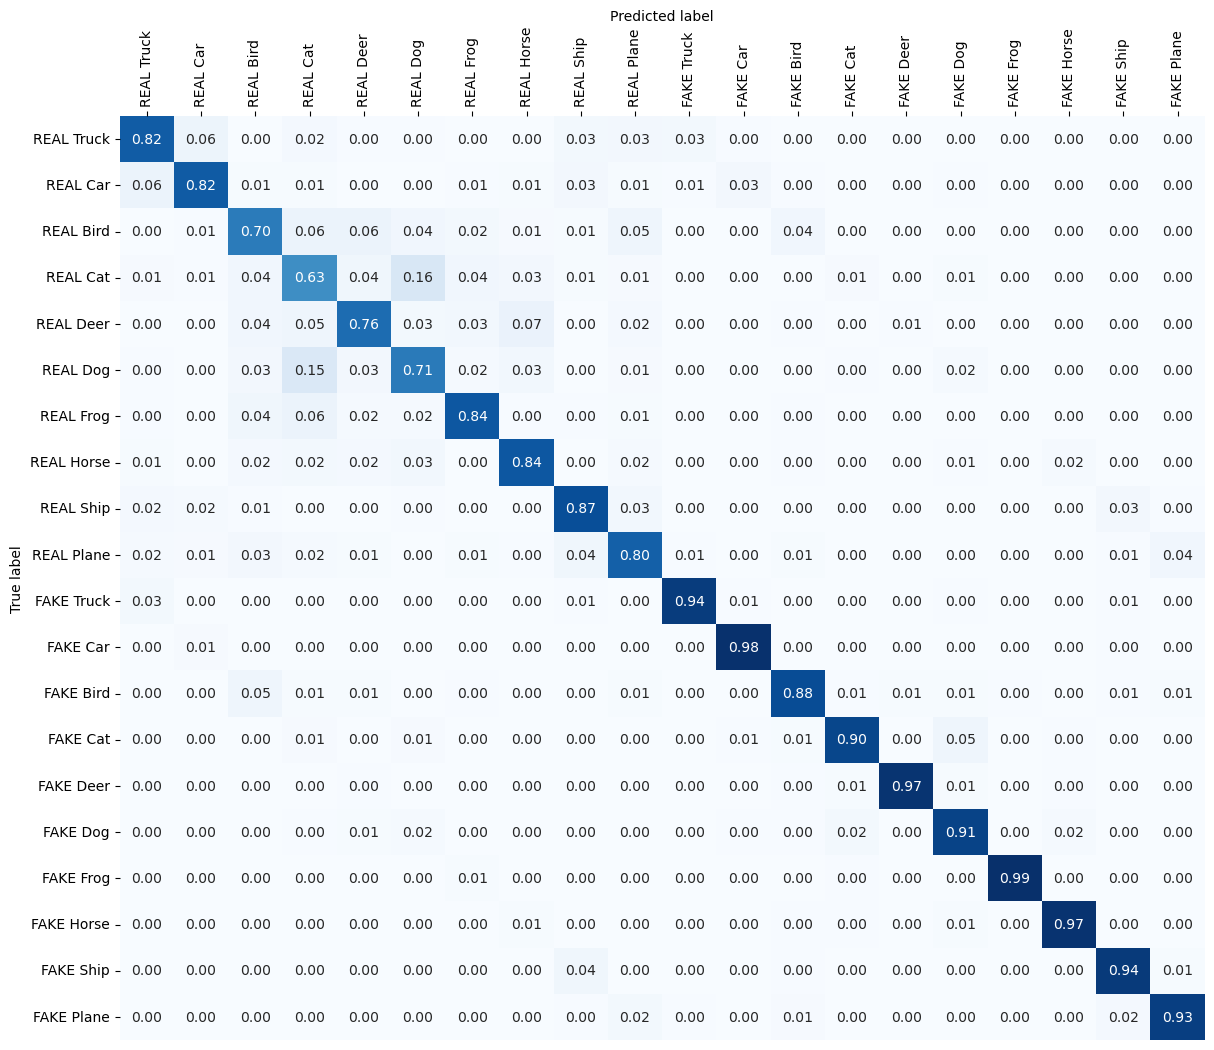

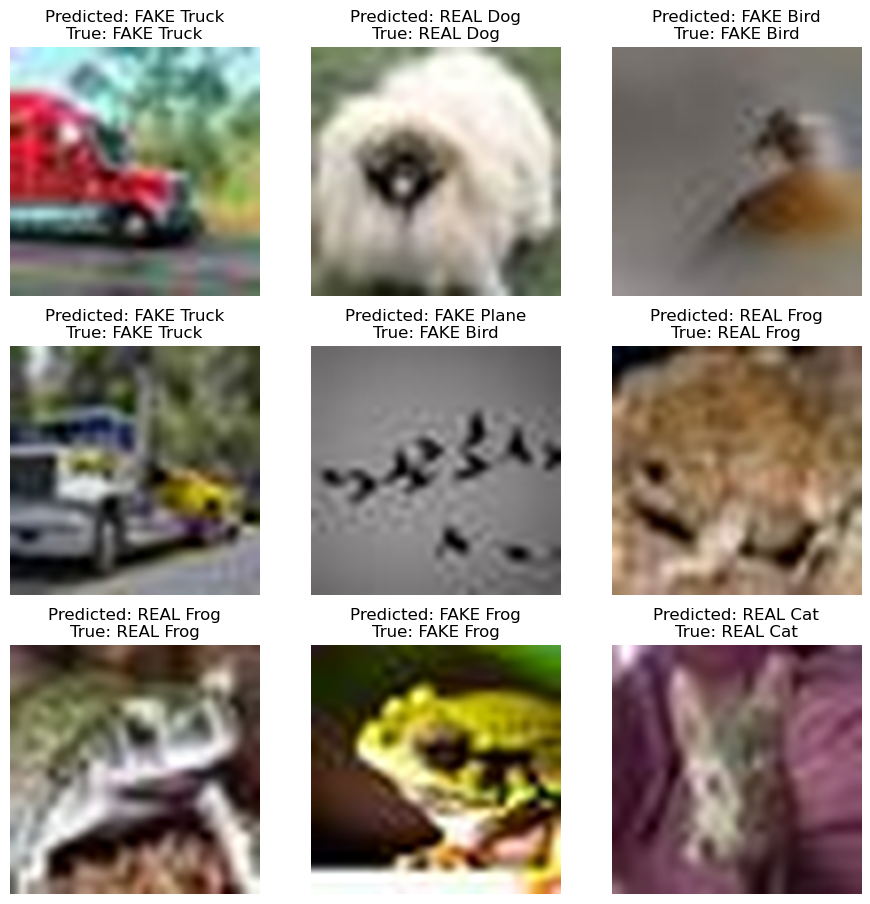

In [6]:
model_init_function = models.multiclass_finetuning
weights_filename = 'multiclass_finetuning_lr0001_batch256_epochs30.pth'
class_names = [labels_map[c] for c in labels_map]
cm_figsize = (14, 12)

# Load the model and the test data
model = model_init_function()
model.load_state_dict(torch.load(os.path.join(script_dir, './weights', weights_filename)))
test_batch_size = 1000
test_loader = DataLoader(test_ds, batch_size=test_batch_size, shuffle=True)

# Plot the confusion matrix
confusion_matrix, test_accuracy = cnn_functions.make_confusion_matrix(device, model, test_loader, len(class_names))
print(f'Test accuracy: {test_accuracy*100:.2f}%')
cnn_functions.plot_confusion_matrix(confusion_matrix, class_names, cm_figsize)

# Visualise some random examples of predictions 
cnn_functions.visualise_samples(model, test_ds, labels_map)



 - multiclass_finetuning_lr1e-01_batch1024_epochs50
Epoch 1; Train err = 21.50%; Val err = 23.80%; Val loss: 0.0075; current lr = 1e-01
Epoch 2; Train err = 14.69%; Val err = 18.87%; Val loss: 0.0059; current lr = 1e-01
Epoch 3; Train err = 13.33%; Val err = 19.46%; Val loss: 0.0061; current lr = 1e-01
Epoch 4; Train err = 13.49%; Val err = 20.01%; Val loss: 0.0066; current lr = 1e-01
Epoch 5; Train err = 11.73%; Val err = 18.85%; Val loss: 0.0066; current lr = 1e-01
EarlyStopping activated.
Stopping training...


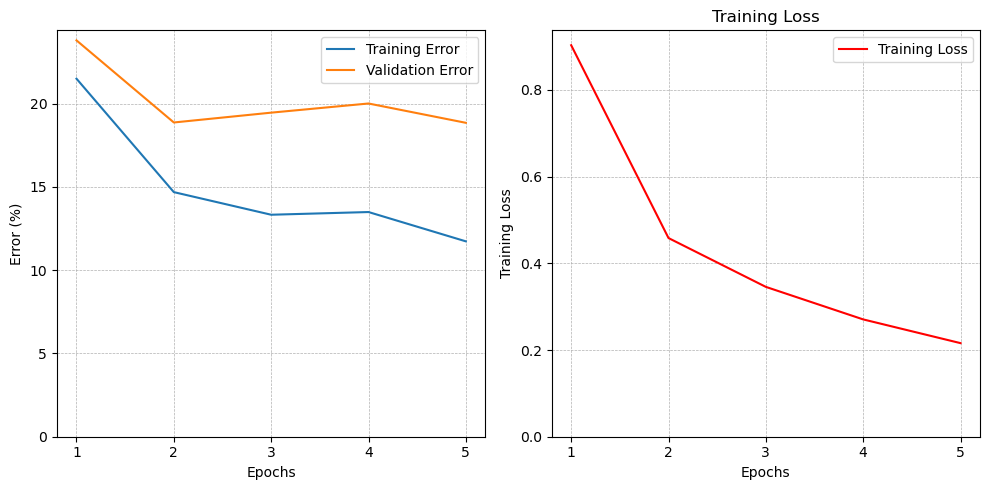

"    # Save the progress\n    torch.save(model.state_dict(), './weights/' + model_name + '.pth')\n    stats_dict = {\n        'train_err': train_err,\n        'val_err': val_err,\n        'train_loss': train_loss\n    }\n    with open('./stats/' + model_name + '.pkl', 'wb') as f:\n        pickle.dump(stats_dict, f)"

In [3]:
import test_functions

model_init_function = models.multiclass_finetuning
epochs = 50
batch_sizes = [1024]
lr = 0.1

val_batch_size = 1000
val_dl = DataLoader(validation_ds, batch_size=val_batch_size)

for batch_size in batch_sizes:
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # Initialize the model
    model = model_init_function()
    model = model.to(device)
    model_name = f"{model_init_function.__name__}_lr{lr:.0e}_batch{batch_size}_epochs{epochs}"
    print("\n\n - " + model_name)

    # Train the model
    train_err, val_err, train_loss = test_functions.train_network(model, device, lr, epochs, train_dl, val_dl)
    cnn_functions.plot_training_stats(train_err, val_err, train_loss)
    
'''    # Save the progress
    torch.save(model.state_dict(), './weights/' + model_name + '.pth')
    stats_dict = {
        'train_err': train_err,
        'val_err': val_err,
        'train_loss': train_loss
    }
    with open('./stats/' + model_name + '.pkl', 'wb') as f:
        pickle.dump(stats_dict, f)'''

In [ ]:
images = data[:16]
img_grid = torchvision.utils.make_grid(images)
writer.add_image('four_fashion_mnist_images', img_grid)


writer.add_histogram('fc1.bias', model.fc1.bias)
writer.add_histogram('fc1.weight', model.fc1.weight, global_step=epoch)
writer.add_histogram('fc1.weight.grad', model.fc1.weight.grad)

